# Anomaly Detection - DBSCAN

In [3]:
import turicreate as tc

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
sf = tc.SFrame('https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/sensor_data.csv')
sf = sf[['0','1']]

Downloading https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/sensor_data.csv to /var/tmp/turicreate-pedrohserrano/30052/1dc4dbb7-0c71-41ca-b9cc-231e984f3df5.csv

Finished parsing file https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/sensor_data.csv

Parsing completed. Parsed 100 lines in 0.035653 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/sensor_data.csv

Parsing completed. Parsed 400 lines in 0.007301 secs.

In [6]:
dbscan_model = tc.dbscan.create(sf, radius=0.2, min_core_neighbors=15)
dbscan_model.summary()

Starting brute force nearest neighbors model training.

Starting blockwise similarity graph construction.

max rows per data block: 8190

number of reference data blocks: 4

+---------+-------------+--------------+

| # Pairs | % Complete. | Elapsed Time |

+---------+-------------+--------------+

| 20000   | 20          | 3.828ms      |

| 100000  | 100         | 6.599ms      |

+---------+-------------+--------------+

[INFO] turicreate.toolkits.clustering.dbscan: Identifying noise points and core points.
[INFO] turicreate.toolkits.clustering.dbscan: Constructing the core point similarity graph.


+-----------------------------+

| Number of components merged |

+-----------------------------+

| 1107                        |

| 0                           |

+-----------------------------+

[INFO] turicreate.toolkits.clustering.dbscan: Processing boundary points.


Class                                    : DBSCANModel

Schema
------
Number of examples                       : 400
Number of feature columns                : 2
Max distance to a neighbor (radius)      : 0.2
Min number of neighbors for core points  : 15
Number of distance components            : 1

Training summary
----------------
Total training time (seconds)            : 1.6439
Number of clusters                       : 2

Accessible fields
-----------------
cluster_id                              : Cluster label for each row in the input dataset.


In [7]:
dbscan_model.cluster_id

row_id,cluster_id,type
396,0,core
394,0,core
391,0,core
331,1,core
310,1,core
287,1,core
268,1,core
178,1,core
68,0,core
241,1,core


Because we generated 2D data, we can plot it and color the points according to the cluster assignments generated by our DBSCAN model. The first step is to join the cluster results back to the original data. Please note: DBSCAN scrambles the row order.

In [8]:
sf = sf.add_row_number('row_id')
sf = sf.join(dbscan_model.cluster_id, on='row_id', how='left')
sf = sf.rename({'cluster_id': 'dbscan_id'})

In [9]:
sf.head()

row_id,0,1,dbscan_id,type
396,1.7349416242071356,-0.11026133461034002,0,core
394,1.2247328937691997,-0.4947457186196592,0,core
391,1.32040559405035,-0.4270878549953882,0,core
331,-0.5397332887744982,0.9826566838398936,1,core
310,0.98427436803332,0.12765409525640342,1,core
287,-0.4198338456017781,0.9333811912148482,1,core
268,-0.82343798480522,0.5813666825540285,1,core
178,0.29393251402005477,0.9492554463458336,1,core
68,1.0394813013834387,-0.4406775837105464,0,core
241,0.20090631805620085,1.0427208786001412,1,core


In [10]:
core_mask = sf['type'] == 'core'
boundary_mask = sf['type'] == 'boundary'
anomalies_mask = sf['type'] == 'noise'

In [12]:
sf[sf['type'] == 'noise']

row_id,0,1,dbscan_id,type
48,0.13881487512582957,0.5994106022129614,None,noise
194,-0.9448685869245562,0.9285845442861648,None,noise
291,1.0915497281031306,-0.0758611562739138,None,noise
53,1.1251705757860009,-0.04738563756788275,None,noise
215,1.3542031357976327,-0.7057855975392487,None,noise
251,1.4900504493276407,0.04948672190154327,None,noise
270,0.9982133669037004,-0.1625716649715506,None,noise


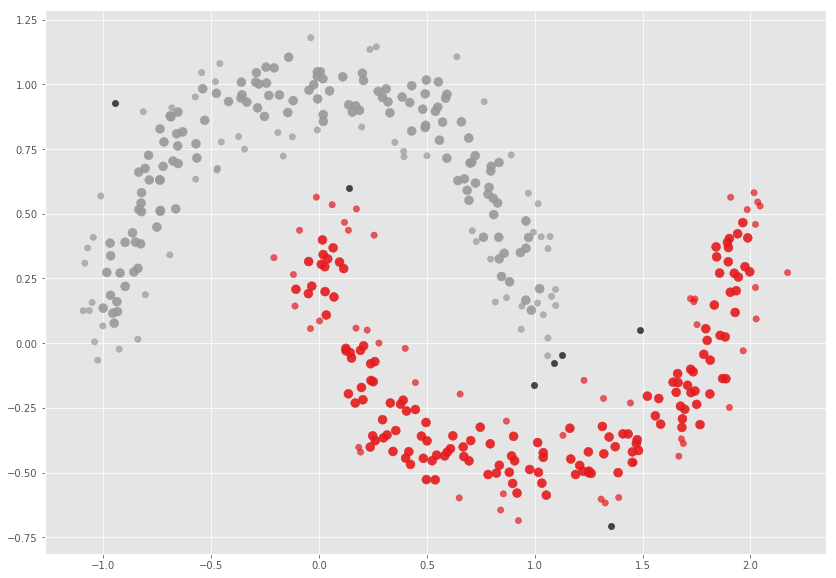

In [18]:
plt.figure(figsize=[14, 10])
plt.scatter(sf['0'][core_mask], sf['1'][core_mask], s=80, alpha=0.9, c=sf['dbscan_id'][core_mask], cmap=plt.cm.Set1)
plt.scatter(sf['0'][boundary_mask], sf['1'][boundary_mask], s=40, alpha=0.7, c=sf['dbscan_id'][boundary_mask], cmap=plt.cm.Set1)
plt.scatter(sf['0'][anomalies_mask], sf['1'][anomalies_mask], s=40, alpha=0.7, c='black')